     |████████████████████████████████| 256kB 8.9MB/s 
     |████████████████████████████████| 296kB 55.6MB/s 
i = 0, discriminant loss = 1.3909, generator loss =0.7025


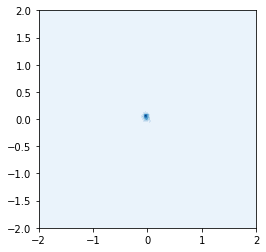

i = 2000, discriminant loss = 1.4092, generator loss =0.9763


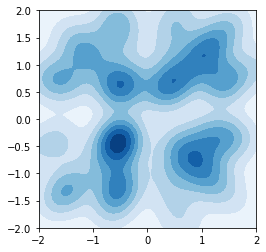

i = 4000, discriminant loss = 1.3133, generator loss =0.6622


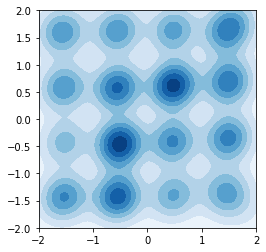

i = 6000, discriminant loss = 1.3804, generator loss =0.6152


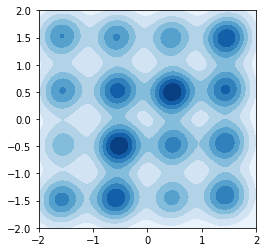

i = 8000, discriminant loss = 1.3693, generator loss =0.6911


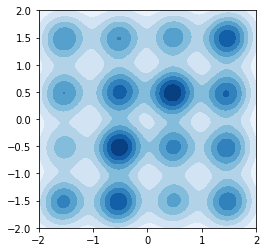

i = 10000, discriminant loss = 1.3761, generator loss =0.6906


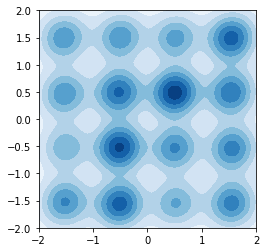

In [1]:
!pip install dm-sonnet
from jax import jit, grad, vmap, random
from functools import partial
import jax
import jax.numpy as jp
from jax.experimental import stax # neural network library
from jax.experimental.stax import GeneralConv, Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax, LeakyRelu, Dropout, Tanh, Sigmoid # neural network layers
from jax.nn import softmax, sigmoid
from jax.nn.initializers import zeros
import matplotlib.pyplot as plt # visualization
import numpy as np
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays
import math
import os
import sonnet as snt
import scipy as sp

#Setup environment and hyperparameters
rng = random.PRNGKey(1234)
hidden_size = 384
g_hidden_size = hidden_size
d_hidden_size = hidden_size
g_out_dim = 2
d_out_dim = 1
z_size = 64
smooth = 0.0
learning_rate = 1e-4
batch_size = 256
epochs = 10001
nsave = 2000

#Define Generator
gen_init, gen_apply = stax.serial(
    Dense(g_hidden_size), Relu,
    Dense(g_hidden_size), Relu,
    Dense(g_hidden_size), Relu,
    Dense(g_hidden_size), Relu,
    Dense(g_hidden_size), Relu,
    Dense(g_hidden_size), Relu,
    Dense(g_out_dim)
)
g_in_shape = (-1, z_size)
_, gen_params = gen_init(rng, g_in_shape)

#Define Discriminator
disc_init, disc_apply = stax.serial(
    Dense(d_hidden_size), Relu,
    Dense(d_hidden_size), Relu,
    Dense(d_hidden_size), Relu,
    Dense(d_hidden_size), Relu,
    Dense(d_hidden_size), Relu,
    Dense(d_hidden_size), Relu,
    Dense(d_out_dim)
)
d_in_shape = (-1, g_out_dim)
_, disc_params = disc_init(rng, d_in_shape)

#Define Losses and Optimizers
def cross_entropy_with_logits(targets, logits):
    predictions = sigmoid(logits)
    return -(targets*jp.log(predictions+1e-9)+(1-targets)*jp.log(1-predictions+1e-9))

def loss(gen_params, disc_params, input_z, input_real):
    g_out = gen_apply(gen_params, input_z)
    d_logits_real = disc_apply(disc_params, input_real)
    d_logits_fake = disc_apply(disc_params, g_out)
    d_loss_real = jp.mean(cross_entropy_with_logits(targets=jp.ones_like(d_logits_real)*(1-smooth), logits=d_logits_real))
    d_loss_fake = jp.mean(cross_entropy_with_logits(targets=jp.zeros_like(d_logits_fake), logits=d_logits_fake))
    d_loss = d_loss_real + d_loss_fake
    g_loss = jp.mean(cross_entropy_with_logits(targets=jp.ones_like(d_logits_fake), logits=d_logits_fake))
    return g_loss, d_loss

g_opt_init, g_opt_update, g_get_params = optimizers.rmsprop(step_size=learning_rate)
d_opt_init, d_opt_update, d_get_params = optimizers.rmsprop(step_size=learning_rate)
g_opt_state = g_opt_init(gen_params)
d_opt_state = d_opt_init(disc_params)

@jit
def step(i, g_opt_state, d_opt_state, input_z, input_real):
    g_params = g_get_params(g_opt_state)
    d_params = d_get_params(d_opt_state)
    g_loss = lambda x: loss(x, d_params, input_z, input_real)[0]
    d_loss = lambda y: loss(g_params, y, input_z, input_real)[1]
    gen_grad = grad(g_loss)(g_params)
    disc_grad = grad(d_loss)(d_params)
    gl, dl = loss(g_params, d_params, input_z, input_real)
    return g_opt_update(i, gen_grad, g_opt_state), d_opt_update(i, disc_grad, d_opt_state), gl, dl

def kde(mu, tau, bbox=None, xlabel="", ylabel="", cmap='Blues'):
    values = np.vstack([mu, tau])
    kernel = sp.stats.gaussian_kde(values)

    fig, ax = plt.subplots()
    ax.axis(bbox)
    ax.set_aspect(abs(bbox[1]-bbox[0])/abs(bbox[3]-bbox[2]))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    xx, yy = np.mgrid[bbox[0]:bbox[1]:300j, bbox[2]:bbox[3]:300j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    f = np.reshape(kernel(positions).T, xx.shape)
    cfset = ax.contourf(xx, yy, f, cmap=cmap)
    plt.show()

def x_real_builder(batch_size):
    sigma = 0.1
    skel = np.array([
        [ 1.50,  1.50],
        [ 1.50,  0.50],
        [ 1.50, -0.50],
        [ 1.50, -1.50],
        [ 0.50,  1.50],
        [ 0.50,  0.50],
        [ 0.50, -0.50],
        [ 0.50, -1.50],
        [-1.50,  1.50],
        [-1.50,  0.50],
        [-1.50, -0.50],
        [-1.50, -1.50],
        [-0.50,  1.50],
        [-0.50,  0.50],
        [-0.50, -0.50],
        [-0.50, -1.50],
    ])
    temp = np.tile(skel, (batch_size // 16 + 1,1))
    mus = temp[0:batch_size,:]
    return mus + sigma * jax.random.normal(rng, (batch_size, g_out_dim))*.2

bbox = [-2, 2, -2, 2]
ztest = [jax.random.normal(rng, (batch_size, z_size)) for i in range(10)]
for i in range(epochs):
    batch_real = x_real_builder(batch_size)
    batch_z = jax.random.normal(rng, (batch_size, z_size))
    g_opt_state, d_opt_state, gl, dl = step(i, g_opt_state, d_opt_state, batch_z, batch_real)
    if i % nsave == 0:
        print('i = %d, discriminant loss = %.4f, generator loss =%.4f' %
              (i, dl, gl))
        gen_params = g_get_params(g_opt_state)
        x_out = np.concatenate(
            [gen_apply(gen_params, zt) for zt in ztest], axis=0)
        kde(x_out[:, 0], x_out[:, 1], bbox=bbox)